

---



# ***`Predicting the sales of products across stores of a retail chain`***



---






  A large Indian retail chain has stores across 3 states in India: Maharashtra, Telangana and 
Kerala. These stores stock products across various categories such as FMCG (fast moving 
consumer goods), eatables / perishables and others. Managing the inventory is crucial for 
the revenue stream of the retail chain. Meeting the demand is important to not lose 
potential revenue, while at the same time stocking excessive products could lead to losses. 



---




In [1]:
#import Neccessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split, GridSearchCV

#import required accuracy metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline





---



---



In [2]:
week_id = pd.read_csv('/content/date_to_week_id_map.csv')
week_id.head(2)

,date,week_id
0,2012-01-01,49
1,2012-01-02,49


In [3]:
product_price = pd.read_csv('/content/product_prices.csv')
product_price.head(3)

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94


In [4]:
train = pd.read_csv('/content/train_data.csv')
train.head(3)

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0


In [5]:
tdf = pd.merge(product_price,week_id, on=['week_id'], how='inner')
df = pd.merge(train,tdf, on =['date', 'product_identifier','outlet'], how='inner')
df.head(6)

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88
5,2012-01-01,611,21,fast_moving_consumer_goods,111,Maharashtra,0,49,2.84





---



---




In [6]:
df.shape

(395000, 9)

In [7]:
#lets check for Null Values
df.isnull().sum()

date                     0
product_identifier       0
department_identifier    0
category_of_product      0
outlet                   0
state                    0
sales                    0
week_id                  0
sell_price               0
dtype: int64

In [8]:
#check the data types
df.dtypes

date                      object
product_identifier         int64
department_identifier      int64
category_of_product       object
outlet                     int64
state                     object
sales                      int64
week_id                    int64
sell_price               float64
dtype: object

In [9]:
#Lets check which columns contains '?'
df[df.columns[(df == '?').any()]].nunique()

Series([], dtype: float64)

In [10]:
#Lets chcek the value counts for categorical data
for i in df.columns:
    if df[i].dtypes == 'object':
        print(df[i].value_counts())
        print('-----------------------------------')

2012-01-01    500
2013-06-03    500
2013-06-05    500
2013-06-06    500
2013-06-07    500
             ... 
2012-09-22    500
2012-09-23    500
2012-09-24    500
2012-09-25    500
2014-02-28    500
Name: date, Length: 790, dtype: int64
-----------------------------------
fast_moving_consumer_goods    229100
drinks_and_food               134300
others                         31600
Name: category_of_product, dtype: int64
-----------------------------------
Maharashtra    158000
Telangana      118500
Kerala         118500
Name: state, dtype: int64
-----------------------------------




---

---




# **Data processing**

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
df['date_year'] = df['date'].dt.year
df['date_mont'] = df['date'].dt.month
#df['date_day'] = df['date'].dt.date

df.drop(['date'], axis=1, inplace =True)
df.head(4)


,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,date_year,date_mont
0,74,11,others,111,Maharashtra,0,49,2.94,2012,1
1,337,11,others,111,Maharashtra,1,49,7.44,2012,1
2,423,12,others,111,Maharashtra,0,49,0.97,2012,1
3,432,12,others,111,Maharashtra,0,49,4.97,2012,1


In [13]:
df['date_mont'].nunique()

12

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_identifier     395000 non-null  int64  
 1   department_identifier  395000 non-null  int64  
 2   category_of_product    395000 non-null  object 
 3   outlet                 395000 non-null  int64  
 4   state                  395000 non-null  object 
 5   sales                  395000 non-null  int64  
 6   week_id                395000 non-null  int64  
 7   sell_price             395000 non-null  float64
 8   date_year              395000 non-null  int64  
 9   date_mont              395000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 33.1+ MB




---



---



In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
product_identifier,395000.0,1509.960000,809.799518,74.00,926.00,1325.00,1753.00,3021.00
department_identifier,395000.0,24.460000,6.337863,11.00,21.00,22.00,31.00,33.00
outlet,395000.0,211.200000,91.161291,111.00,113.00,221.50,331.00,333.00
sales,395000.0,1.228919,3.595266,0.00,0.00,0.00,1.00,293.00
week_id,395000.0,105.070886,32.578749,49.00,77.00,105.00,133.00,161.00
sell_price,395000.0,4.987644,3.874444,0.05,2.68,3.98,6.48,44.36
date_year,395000.0,2012.611392,0.622061,2012.00,2012.00,2013.00,2013.00,2014.00
date_mont,395000.0,6.143038,3.576092,1.00,3.00,6.00,9.00,12.00




---



---



In [16]:
#df_new1= pd.get_dummies(df, columns=['state','category_of_product','outlet','department_identifier'],drop_first=True)




---



---



In [17]:
#df_new1.head(5)

In [18]:
#df_new1.info()

In [19]:
df.shape

(395000, 10)



---



---



---



In [20]:
display(df.drop_duplicates())

,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,date_year,date_mont
0,74,11,others,111,Maharashtra,0,49,2.94,2012,1
1,337,11,others,111,Maharashtra,1,49,7.44,2012,1
2,423,12,others,111,Maharashtra,0,49,0.97,2012,1
3,432,12,others,111,Maharashtra,0,49,4.97,2012,1
4,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88,2012,1
...,...,...,...,...,...,...,...,...,...,...
394975,1328,22,fast_moving_consumer_goods,333,Kerala,1,161,4.78,2014,2
394978,1472,22,fast_moving_consumer_goods,333,Kerala,1,161,3.82,2014,2
394992,2794,33,drinks_and_food,333,Kerala,2,161,3.98,2014,2
394994,2853,33,drinks_and_food,333,Kerala,4,161,3.98,2014,2




---



---



---



## **Split Data into x & y**



---




---



---



In [23]:
#lets saperate data into label and features
x = df.drop(columns = 'sales')
y = df["sales"]

In [24]:
x.skew()

product_identifier       0.550679
department_identifier   -0.048981
outlet                   0.190797
week_id                 -0.000099
sell_price               3.269741
date_year                0.503524
date_mont                0.094646
dtype: float64



---



---



In [25]:
x['sell_price'] = np.log(x['sell_price'])
#x['category_of_product_others'] = np.log(x['category_of_product_others'])
#x['department_identifier_12'] = np.log(x['department_identifier_12'])

In [26]:
x.skew()

product_identifier       0.550679
department_identifier   -0.048981
outlet                   0.190797
week_id                 -0.000099
sell_price              -1.107762
date_year                0.503524
date_mont                0.094646
dtype: float64

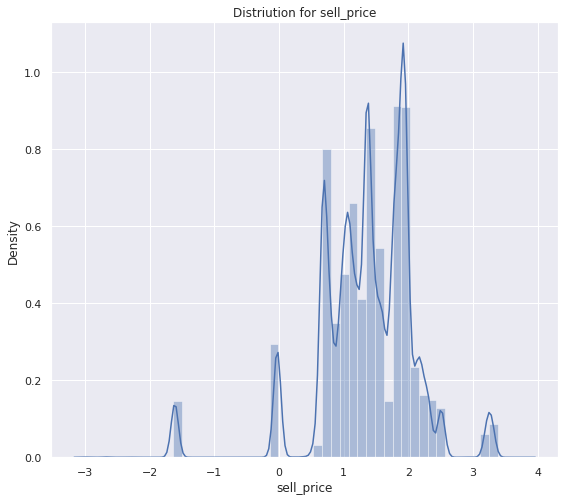

In [27]:
sns.set_theme()
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.distplot(x.sell_price)
plt.title('Distriution for sell_price')

plt.show()



---



---



In [28]:
cat_data  = x.select_dtypes(include = 'object')
num_data = x.select_dtypes(include = [np.number])
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
for i in cat_data.columns:
    cat_data[i] = enc.fit_transform(cat_data[i].values.reshape(-1,1))

In [29]:
cat_data

,category_of_product,state
0,2.0,1.0
1,2.0,1.0
2,2.0,1.0
3,2.0,1.0
4,1.0,1.0
...,...,...
394995,0.0,0.0
394996,0.0,0.0
394997,0.0,0.0
394998,0.0,0.0


In [30]:
num_data = x.select_dtypes(include = [np.number])

In [31]:
num_data.head(4)

,product_identifier,department_identifier,outlet,week_id,sell_price,date_year,date_mont
0,74,11,111,49,1.078410,2012,1
1,337,11,111,49,2.006871,2012,1
2,423,12,111,49,-0.030459,2012,1
3,432,12,111,49,1.603420,2012,1


In [32]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_identifier     395000 non-null  int64  
 1   department_identifier  395000 non-null  int64  
 2   outlet                 395000 non-null  int64  
 3   week_id                395000 non-null  int64  
 4   sell_price             395000 non-null  float64
 5   date_year              395000 non-null  int64  
 6   date_mont              395000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 24.1 MB


In [33]:
num = num_data.reset_index(drop=True)
cat_data = cat_data.reset_index(drop=True)

## **Combine Catagorical and Numerical **

In [34]:
X = pd.concat([num, cat_data], axis = 1)

In [35]:
X.head()

,product_identifier,department_identifier,outlet,week_id,sell_price,date_year,date_mont,category_of_product,state
0,74,11,111,49,1.078410,2012,1,2.0,1.0
1,337,11,111,49,2.006871,2012,1,2.0,1.0
2,423,12,111,49,-0.030459,2012,1,2.0,1.0
3,432,12,111,49,1.603420,2012,1,2.0,1.0
4,581,21,111,49,1.585145,2012,1,1.0,1.0


In [37]:
X.shape

(395000, 9)



---



---



---



# Applying standard scaler to numerical data



---



---



In [53]:
#num_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [56]:
#num_data.fillna(0, inplace=True)

In [38]:
#Lets bring all numerical features to common scale by applying standard scaler
scaler = StandardScaler()
num = scaler.fit_transform(num_data)
num = pd.DataFrame(num,columns=num_data.columns)

In [39]:
num

,product_identifier,department_identifier,outlet,week_id,sell_price,date_year,date_mont
0,-1.773231,-2.123747,-1.099152,-1.721090,-0.391401,-0.982851,-1.438175
1,-1.448459,-2.123747,-1.099152,-1.721090,0.857092,-0.982851,-1.438175
2,-1.342260,-1.965965,-1.099152,-1.721090,-1.882487,-0.982851,-1.438175
3,-1.331146,-1.965965,-1.099152,-1.721090,0.314575,-0.982851,-1.438175
4,-1.147150,-0.545926,-1.099152,-1.721090,0.290002,-0.982851,-1.438175
...,...,...,...,...,...,...,...
394995,1.756042,1.347459,1.336095,1.716738,-0.466648,2.232272,-1.158539
394996,1.759746,1.347459,1.336095,1.716738,-4.005725,2.232272,-1.158539
394997,1.844953,1.347459,1.336095,1.716738,-0.609401,2.232272,-1.158539
394998,1.849892,1.347459,1.336095,1.716738,-0.922974,2.232272,-1.158539




---



---



In [40]:
X = num_data

In [ ]:
#X.drop(['week_id'], axis=1, inplace =True)

In [47]:
#X.drop(['sell_price'], axis=1, inplace =True )

In [41]:
X.shape

(395000, 7)

In [42]:
X

,product_identifier,department_identifier,outlet,week_id,sell_price,date_year,date_mont
0,74,11,111,49,1.078410,2012,1
1,337,11,111,49,2.006871,2012,1
2,423,12,111,49,-0.030459,2012,1
3,432,12,111,49,1.603420,2012,1
4,581,21,111,49,1.585145,2012,1
...,...,...,...,...,...,...,...
394995,2932,33,333,161,1.022451,2014,2
394996,2935,33,333,161,-1.609438,2014,2
394997,3004,33,333,161,0.916291,2014,2
394998,3008,33,333,161,0.683097,2014,2




---



---



---



In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_identifier     395000 non-null  int64  
 1   department_identifier  395000 non-null  int64  
 2   outlet                 395000 non-null  int64  
 3   week_id                395000 non-null  int64  
 4   sell_price             395000 non-null  float64
 5   date_year              395000 non-null  int64  
 6   date_mont              395000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 24.1 MB


In [44]:
X.isna().sum().sum()

0






---



---



---



## **Finding best random_state**

In [45]:
#to find random stat which gives maximum r2_score

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
max_r_score=0
r_state = 0
for i in range(50,1000):
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = r_state)
    reg = LinearRegression()
    reg.fit(x_train,y_train)
    y_pred = reg.predict(x_test)
    r2_scr=r2_score(y_test,y_pred)
    if r2_scr > max_r_score:
        max_r_score = r2_scr
        r_state = i
print("max r2 score is",max_r_score,"on Random State",r_state)

max r2 score is 0.15321554443200192 on Random State 52


In [47]:
#lets split our train data into train and test part with our best random state
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 52)



---



---



---



## **Building a function for model with evaluation**

In [48]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [49]:
def BuiltModel(model):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    r2score = r2_score(y_test,pred)*100

    #evaluation
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,pred)
    print("MAE :", mae)
    print("RMSE :", rmse)
    print('------------------------------')

    # r2 score
    print("Training r2 Score in percentage :", r2_score(y_train,y_pred)*100,'%')
    print(f"Testing r2 Score in percentage :", r2score,"%")
    print('------------------------------')

    #cross validation score
    scores = cross_val_score(model, X, y, cv = 10).mean()*100
    print("\nCross validation score :", scores)

    #result of accuracy minus cv score
    result = r2score - scores
    print("\nAccuracy Score - Cross Validation Score :", result)

    sns.regplot(y_test,pred)
    plt.show()



---



---



---



## **LinearRegression Model**



---



---



MAE : 1.5539506887346604
RMSE : 3.4169468765554036
------------------------------
Training r2 Score in percentage : 14.124806815972502 %
Testing r2 Score in percentage : 13.983547228958294 %
------------------------------

Cross validation score : 14.123179739765487

Accuracy Score - Cross Validation Score : -0.13963251080719274


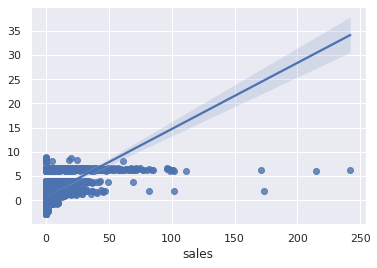

In [50]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
BuiltModel(lr)



---



---



---



## **DecisionTreeRegressor Model**



---



---



MAE : 1.0065104038577457
RMSE : 2.8106028302911006
------------------------------
Training r2 Score in percentage : 62.73187372435176 %
Testing r2 Score in percentage : 41.80253958993648 %
------------------------------

Cross validation score : 8.468858348086059

Accuracy Score - Cross Validation Score : 33.33368124185042


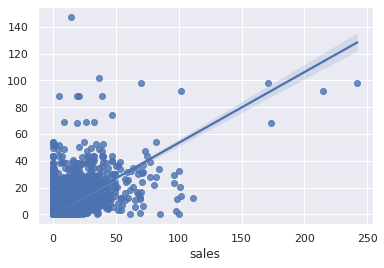

In [51]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
BuiltModel(dt)





---



---



## **RandomForestRegressor Model**



---



---



MAE : 0.9995534305167465
RMSE : 2.7717605765389024
------------------------------
Training r2 Score in percentage : 62.42269687928859 %
Testing r2 Score in percentage : 43.39999079542039 %
------------------------------

Cross validation score : 19.596569677155948

Accuracy Score - Cross Validation Score : 23.803421118264446


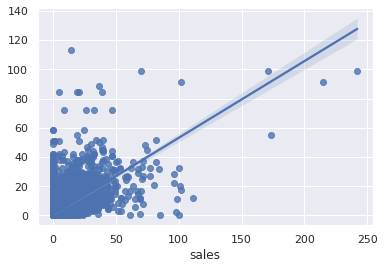

In [52]:
#model with RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
BuiltModel(rf)



---



---



---



## **XGBRegressor model**



---



---



MAE : 1.215378403507607
RMSE : 3.0315908852606968
------------------------------
Training r2 Score in percentage : 33.007588819829905 %
Testing r2 Score in percentage : 32.29102173010007 %
------------------------------

Cross validation score : 30.86178126254671

Accuracy Score - Cross Validation Score : 1.4292404675533597


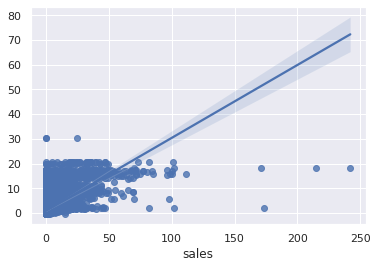

In [53]:
from xgboost import XGBRegressor
xgb = XGBRegressor(verbosity = 0)
BuiltModel(xgb)



---



---


## **ExtraTreesRegressor model**




---



MAE : 1.0060572773960217
RMSE : 2.813269554679096
------------------------------
Training r2 Score in percentage : 62.73187372435177 %
Testing r2 Score in percentage : 41.69205068609231 %
------------------------------

Cross validation score : 20.726759577025984

Accuracy Score - Cross Validation Score : 20.965291109066325


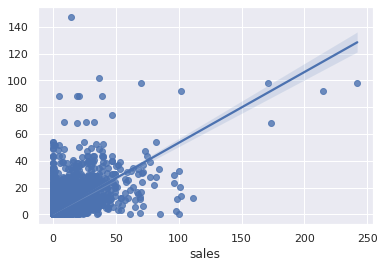

In [54]:
from sklearn.ensemble import ExtraTreesRegressor
ext = ExtraTreesRegressor()
BuiltModel(ext)

## **LGBMRegressor model**

MAE : 1.092148614949459
RMSE : 2.720565076771322
------------------------------
Training r2 Score in percentage : 46.614938893342305 %
Testing r2 Score in percentage : 45.471529927314 %
------------------------------

Cross validation score : 36.47715645157663

Accuracy Score - Cross Validation Score : 8.994373475737369


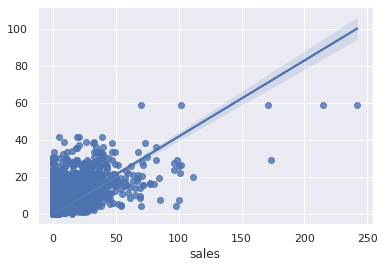

In [56]:
from lightgbm import LGBMRegressor
gbm = LGBMRegressor()
BuiltModel(gbm)



---



---



---



## **HyperParameter Tuning**



---



---



In [57]:
#lets selects different parameters for tuning
grid_params = {
                'max_depth': [8,9,10,12],
                'n_estimators':[500,700,900,1000],
                'min_samples_split': [2]
                }

In [58]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(RandomForestRegressor(), grid_params, cv = 5)
GCV.fit(x_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
GCV.best_params_       #printing the best parameters found by GridSearchCV







---



---



## **Final Model**





---



---



In [125]:
#lets train and test our final model with best parameters
model = LGBMRegressor(max_depth = 12,min_samples_split = 2, n_estimators = 700)
model.fit(x_train,y_train)
pred = model.predict(x_test)

r2score = r2_score(y_test,pred)*100

#evaluation
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,pred)
print("MAE :", mae)
print("RMSE :", rmse)
print('------------------------------')

# r2 score

print(f" \nr2 Score:", r2score,"%")

MAE : 1.0073004293456076
RMSE : 2.6188707235025213
------------------------------
 
r2 Score: 49.47187340944937 %




---



---



## **Lets see final Actual Vs Predicted sample**

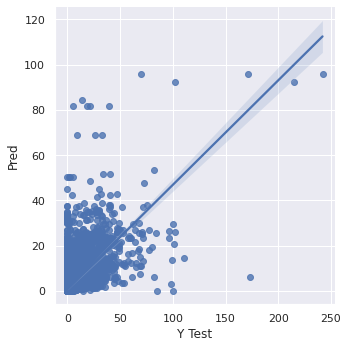

In [61]:
data = pd.DataFrame({'Y Test':y_test , 'Pred':pred},columns=['Y Test','Pred'])
sns.lmplot(x='Y Test',y='Pred',data=data,palette='rainbow')
plt.show()



---



---



## **Model Saving**

In [62]:
import joblib
joblib.dump(model,"122_hackaton.pkl")

['122_hackaton.pkl']

In [63]:
model = joblib.load('122_hackaton.pkl')




---



---



# ***Making predictions for test dataset using final model***



---



---



In [77]:
#week2_id = pd.read_csv('/content/date_to_week_id_map.csv')
#week2_id.head(2)

In [126]:
product2_price = pd.read_csv('/content/product_prices.csv')
product2_price.head(3)

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94


In [127]:
test = pd.read_csv('/content/test_data.csv')
test.head(5)

,id,date,product_identifier,department_identifier,category_of_product,outlet,state
0,1,3/1/2014,74,11,others,111,Maharashtra
1,2,3/1/2014,337,11,others,111,Maharashtra
2,3,3/1/2014,423,12,others,111,Maharashtra
3,4,3/1/2014,432,12,others,111,Maharashtra
4,5,3/1/2014,581,21,fast_moving_consumer_goods,111,Maharashtra


In [128]:
#tdf2 = pd.merge(product2_price, week2_id, on=['week_id'], how='inner')

In [129]:
df_test = pd.merge(test,product2_price, on =['product_identifier','outlet'], how='inner')
df_test.head(6)

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,3/1/2014,74,11,others,111,Maharashtra,49,2.94
1,1,3/1/2014,74,11,others,111,Maharashtra,50,2.94
2,1,3/1/2014,74,11,others,111,Maharashtra,51,2.94
3,1,3/1/2014,74,11,others,111,Maharashtra,52,2.94
4,1,3/1/2014,74,11,others,111,Maharashtra,53,2.94
5,1,3/1/2014,74,11,others,111,Maharashtra,54,2.94




---



---



In [130]:
df_test.shape

(1829000, 9)

In [131]:
p_ID = df_test['id']
df_test = df_test.drop(columns='id')

In [132]:
df_test.shape

(1829000, 8)

In [133]:
df_test.reset_index(inplace=True)

In [134]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829000 entries, 0 to 1828999
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   index                  int64  
 1   date                   object 
 2   product_identifier     int64  
 3   department_identifier  int64  
 4   category_of_product    object 
 5   outlet                 int64  
 6   state                  object 
 7   week_id                int64  
 8   sell_price             float64
dtypes: float64(1), int64(5), object(3)
memory usage: 125.6+ MB


In [135]:
df_test.isna().sum().sum()

0

In [136]:
df_test['date'] = pd.to_datetime(df_test['date'])

In [137]:
df_test['date_year'] = df_test['date'].dt.year
df_test['date_mont'] = df_test['date'].dt.month
#df_test['date_day'] = df_test['date'].dt.date

df_test.drop(['date'], axis=1, inplace =True)
df_test.head(4)


,index,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,date_year,date_mont
0,0,74,11,others,111,Maharashtra,49,2.94,2014,3
1,1,74,11,others,111,Maharashtra,50,2.94,2014,3
2,2,74,11,others,111,Maharashtra,51,2.94,2014,3
3,3,74,11,others,111,Maharashtra,52,2.94,2014,3


In [138]:
#df_new1= pd.get_dummies(df_test, columns=['state','category_of_product'],drop_first=True)


In [139]:
display(df_test.drop_duplicates())

,index,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,date_year,date_mont
0,0,74,11,others,111,Maharashtra,49,2.94,2014,3
1,1,74,11,others,111,Maharashtra,50,2.94,2014,3
2,2,74,11,others,111,Maharashtra,51,2.94,2014,3
3,3,74,11,others,111,Maharashtra,52,2.94,2014,3
4,4,74,11,others,111,Maharashtra,53,2.94,2014,3
...,...,...,...,...,...,...,...,...,...,...
1828995,1828995,3021,33,drinks_and_food,333,Kerala,162,2.08,2014,3
1828996,1828996,3021,33,drinks_and_food,333,Kerala,163,2.08,2014,3
1828997,1828997,3021,33,drinks_and_food,333,Kerala,164,2.08,2014,3
1828998,1828998,3021,33,drinks_and_food,333,Kerala,165,2.08,2014,3


In [140]:
#####################################################################################

In [141]:
#lets saperate data into label and features
#x1 = df_test.drop(columns = 'sales')
#y1 = df_test["sales"]

In [142]:
x1 =df_test

In [143]:
x1.skew()

index                    4.119056e-16
product_identifier       5.506774e-01
department_identifier   -4.898133e-02
outlet                   1.907968e-01
week_id                  0.000000e+00
sell_price               3.267431e+00
date_year                0.000000e+00
date_mont                0.000000e+00
dtype: float64

In [153]:
x1['sell_price'] = np.log(x1['sell_price'])
x1['product_identifier'] = np.log(x1['product_identifier'])
x1['department_identifier'] = np.log(x1['department_identifier'])
x1['product_identifier'] = np.log(x1['product_identifier'])

In [154]:
x1.skew()

index                    4.119056e-16
product_identifier                NaN
department_identifier   -1.156609e+00
outlet                   1.907968e-01
week_id                  0.000000e+00
sell_price              -1.398454e+00
date_year                0.000000e+00
date_mont                0.000000e+00
dtype: float64

In [155]:
catt_data  = x1.select_dtypes(include = 'object')
numm_data = x1.select_dtypes(include = [np.number])
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
for i in cat_data.columns:
    catt_data[i] = enc.fit_transform(catt_data[i].values.reshape(-1,1))

In [156]:
catt_data.head(6)

,category_of_product,state
0,2.0,1.0
1,2.0,1.0
2,2.0,1.0
3,2.0,1.0
4,2.0,1.0
5,2.0,1.0


In [157]:
numm_data.head(6)

,index,product_identifier,department_identifier,outlet,week_id,sell_price,date_year,date_mont
0,0,NaN,0.874591,111,49,-2.58379,2014,3
1,1,NaN,0.874591,111,50,-2.58379,2014,3
2,2,NaN,0.874591,111,51,-2.58379,2014,3
3,3,NaN,0.874591,111,52,-2.58379,2014,3
4,4,NaN,0.874591,111,53,-2.58379,2014,3
5,5,NaN,0.874591,111,54,-2.58379,2014,3


In [158]:
numm_data = x1.select_dtypes(include = [np.number])

In [159]:
#Lets bring all numerical features to common scale by applying standard scaler
scaler = StandardScaler()
numm = scaler.fit_transform(numm_data)
numm = pd.DataFrame(numm,columns=numm_data.columns)

In [160]:
numm.shape

(1829000, 8)

In [161]:
X.shape

(395000, 7)

In [162]:
X.columns

Index(['product_identifier', 'department_identifier', 'outlet', 'week_id',
       'sell_price', 'date_year', 'date_mont'],
      dtype='object')

In [163]:
numm.columns

Index(['index', 'product_identifier', 'department_identifier', 'outlet',
       'week_id', 'sell_price', 'date_year', 'date_mont'],
      dtype='object')

In [164]:
numm.drop(['index'], axis=1, inplace =True )

In [165]:
numm.head(9)

,product_identifier,department_identifier,outlet,week_id,sell_price,date_year,date_mont
0,NaN,-2.864323,-1.099152,-1.717434,-2.132936,0.0,0.0
1,NaN,-2.864323,-1.099152,-1.688076,-2.132936,0.0,0.0
2,NaN,-2.864323,-1.099152,-1.658718,-2.132936,0.0,0.0
3,NaN,-2.864323,-1.099152,-1.629361,-2.132936,0.0,0.0
4,NaN,-2.864323,-1.099152,-1.600003,-2.132936,0.0,0.0
5,NaN,-2.864323,-1.099152,-1.570645,-2.132936,0.0,0.0
6,NaN,-2.864323,-1.099152,-1.541287,-2.132936,0.0,0.0
7,NaN,-2.864323,-1.099152,-1.511929,-2.132936,0.0,0.0
8,NaN,-2.864323,-1.099152,-1.482571,-2.132936,0.0,0.0




---



---



In [166]:
#lets predict the price with our best model
prediction = model.predict(numm)

In [167]:
prediction

array([8.01182196, 8.01182196, 8.01182196, ..., 0.59401746, 0.59401746,
       0.59401746])

In [168]:
#lets make the dataframe for prediction
sales_value = pd.DataFrame(prediction, columns=["sale"])



---



---



In [169]:
sub_file = pd.concat([p_ID, sales_value], axis = 1)

In [170]:
sub_file

,id,sale
0,1,8.011822
1,1,8.011822
2,1,8.011822
3,1,8.011822
4,1,8.011822
...,...,...
1828995,15500,0.594017
1828996,15500,0.594017
1828997,15500,0.594017
1828998,15500,0.594017




---






In [171]:
#Lets save the submission to csv
sub_file.to_csv("Srivathsa_N_T_119_MITH.csv",index=False)



---



---




# ***THANK YOU***



---



---

